# <b>Setup Super Mario Environment</b>

In [3]:
# !pip install gym_super_mario_bros==7.3.0 nes_py

In [4]:
import gym_super_mario_bros

from nes_py.wrappers import JoypadSpace

from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

from matplotlib import pyplot as plt

import gym

# Below code is to prevent kernel from crashing
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [5]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [6]:
env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

C:\Users\Dhiraj\anaconda3\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


In [7]:
done = True
for i in range(10000):
    if done:
        env.reset()
    state, reward, terminated, truncated, info = env.step(env.action_space.sample())
    env.render()
    done = terminated or truncated
env.close()

In [8]:
env.close()

In [9]:
state, _ = env.reset()
print(state.shape)

(240, 256, 3)


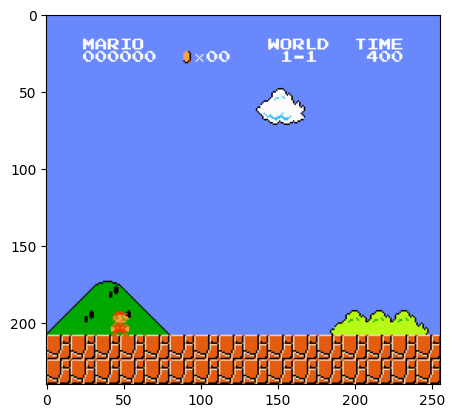

In [10]:
plt.imshow(state)

 # <b>Preprocess Environment</b>.

In [12]:
# !pip install torch torchvision torchaudio
# !pip install stable-baselines3[extra] --no-deps
# !pip install tensorboard opencv-python pygame
# !pip install matplotlib
# !pip install shimmy>=0.2.1
# !pip install gymnasium==0.29.0

In [14]:
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [17]:
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)

env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode='human')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

C:\Users\Dhiraj\anaconda3\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\Dhiraj\anaconda3\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [18]:
print(env.observation_space.shape)

(240, 256, 3)


In [25]:
env = GrayScaleObservation(env, keep_dim=True)
state, _ = env.reset()
state.shape

(240, 256, 1)

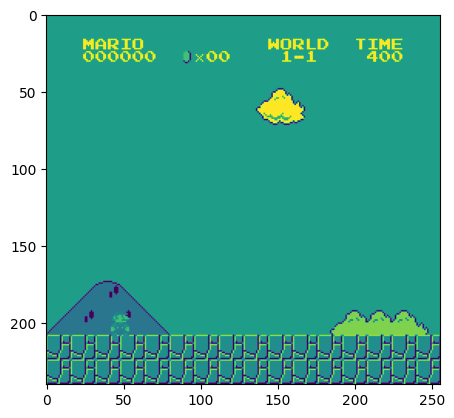

In [26]:
plt.imshow(state)

(1, 240, 256, 1)


C:\Users\Dhiraj\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


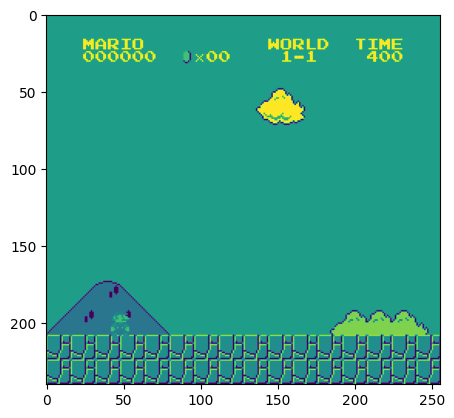

In [30]:
env = DummyVecEnv([lambda:env])
state = env.reset()
print(state.shape)
plt.imshow(state[0])

(1, 240, 256, 4)


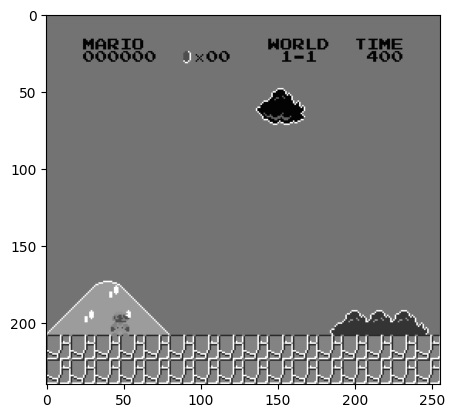

In [31]:
env = VecFrameStack(env, 4, channels_order='last')
state = env.reset()
print(state.shape)
plt.imshow(state[0])

In [34]:
state, reward, done, info = env.step([env.action_space.sample()])

C:\Users\Dhiraj\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [38]:
state.shape

(1, 240, 256, 4)

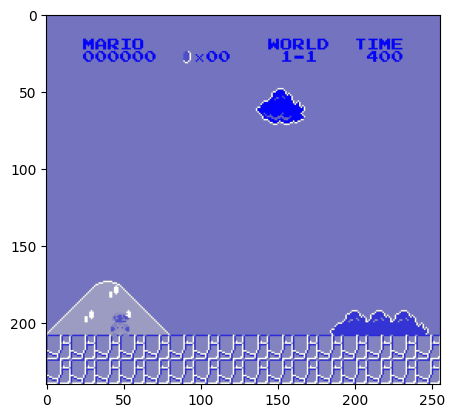

In [40]:
plt.imshow(state[0])

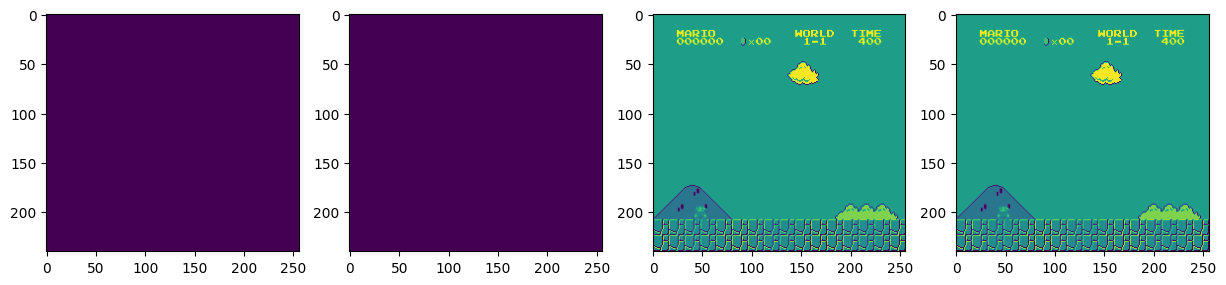

In [42]:
plt.figure(figsize=(15,12))
for frame in range(state.shape[3]):
    plt.subplot(1,4,frame+1)
    plt.imshow(state[0][:,:,frame])
plt.show()

# Training Model

In [45]:
import os
import time
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [47]:

class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
            self.model.save(model_path)
        return True

In [49]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [51]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [53]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

In [55]:
start = time.time()
model.learn(total_timesteps=4000000, callback = callback)
stop = time.time()
print(f"{(stop-start)/60:.2f} min")

# Retrain the model

In [58]:
model = PPO.load("./train/best_model_120000", env=env)

Wrapping the env in a VecTransposeImage.


In [60]:
start = time.time()
model.learn(total_timesteps=80000, callback = callback)
stop = time.time()
print(f"{(stop-start)/60:.2f} min")

Logging to ./logs/PPO_7


C:\Users\Dhiraj\anaconda3\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 65  |
|    iterations      | 1   |
|    time_elapsed    | 7   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 13           |
|    iterations           | 2            |
|    time_elapsed         | 74           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0008039146 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.86        |
|    explained_variance   | 0.403        |
|    learning_rate        | 1e-06        |
|    loss                 | 194          |
|    n_updates            | 1950         |
|    policy_gradient_loss | 0.000928     |
|    value_loss           | 490          |
------------------------------------------
-----------------------

KeyboardInterrupt: 

# Testing Model

In [62]:
model = PPO.load("./train/best_model_1000000")

In [86]:
state = env.reset()
action, state = model.predict(state)
SIMPLE_MOVEMENT[action[0]]

['right', 'A']

In [92]:
state = env.reset()
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 

In [94]:
env.close()

AttributeError: 'DummyVecEnv' object has no attribute 'closse'